# An comparison of clustering approaches to a sample of the Movies Dataset

## Data Preprocessing

In [49]:
# Download packages if necessary:

#!pip install kmodes
#!pip install scikit-learn

In [50]:
import os
import sys

In [51]:
current_dir = os.getcwd()

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

In [52]:
sys.path.append(parent_dir)

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [54]:
movies_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

In [55]:
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

From now on, we work with the columns that contain useful tabular information.  
We remove `budget, revenue and popularity` due to high prevalence of missing values.

In [56]:
movies_metadata = movies_metadata.loc[:,[
    'title', 'adult', 'genres', 'id', 'original_language',
    'production_companies', 'production_countries', 'release_date',
    'runtime', 'spoken_languages', 'status', 'vote_average', 'vote_count'
]].set_index('id')

In [57]:
def zero_to_nan(value):
    try:
        if float(value) < 1 and float(value) > -1:
            return np.NaN
        else:
            return value
    except ValueError:
        print(value)
        return np.NaN

In [58]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0
8844,Jumanji,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0
31357,Waiting to Exhale,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0
11862,Father of the Bride Part II,False,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0


In [59]:
movies_metadata['runtime'] = movies_metadata['runtime'].apply(zero_to_nan)
print("1")
movies_metadata['vote_average'] = movies_metadata['vote_average'].apply(zero_to_nan)

1


In [60]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0
8844,Jumanji,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0
31357,Waiting to Exhale,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0
11862,Father of the Bride Part II,False,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0


In [61]:
movies_metadata.loc["461257",:].genres

'[]'

In [62]:
unpackable_cols = ('genres', 'production_companies', 'production_countries',
                   'spoken_languages')

for col in unpackable_cols:
    movies_metadata[col] = movies_metadata[col].apply(lambda x: np.NaN if x == '[]' else x)    

In [63]:
main_keys = {
    'genres':'name',
    'production_companies':'id',
    'production_countries':'iso_3166_1',
    'spoken_languages':'iso_639_1'
}

def unpack_list_of_dicts(value_list:str,        # organized like List[Dict[str, Any]]
                         main_key:str) -> set:
    out = []
    
    if not isinstance(value_list, str):
        return np.NaN

    clean_value_list = value_list[2:-2].replace(", {", "").split("}")

    for val in clean_value_list:
        sep_val = val.split(', ')
        main_key_mask = [main_key in e for e in sep_val]
        try:
            main_component = list(compress(sep_val, main_key_mask))[0]
        except IndexError:  # Weird cases with wrong typing
            return np.NaN
        clean_component = main_component.split(': ')[1].replace("'","")
        out.append(clean_component)
    return out 


for col in unpackable_cols:
    key = main_keys[col]  
    movies_metadata[col].apply(lambda x: unpack_list_of_dicts(x, main_key=key))

In [64]:
for col in unpackable_cols:
    key = main_keys[col]
    movies_metadata[col] = movies_metadata[col].apply(lambda x: unpack_list_of_dicts(x, main_key=key))

In [65]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,81.0,[en],Released,7.7,5415.0
8844,Jumanji,False,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,104.0,"[en, fr]",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,101.0,[en],Released,6.5,92.0
31357,Waiting to Exhale,False,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,127.0,[en],Released,6.1,34.0
11862,Father of the Bride Part II,False,[Comedy],en,"[5842, 9195]",[US],1995-02-10,106.0,[en],Released,5.7,173.0


Finally, for preprocessing, we scale the numerical variables to mitigate the influence of differently-scaled variables on the clustering.

In [66]:
scaler = MinMaxScaler()

movies_metadata[['runtime', 'vote_average', 'vote_count']] = scaler.fit_transform(movies_metadata[['runtime', 'vote_average', 'vote_count']])

movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,0.063745,[en],Released,0.744444,0.384725
8844,Jumanji,False,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,0.082072,"[en, fr]",Released,0.655556,0.171439
15602,Grumpier Old Men,False,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,0.079681,[en],Released,0.611111,0.006536
31357,Waiting to Exhale,False,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,0.100398,[en],Released,0.566667,0.002416
11862,Father of the Bride Part II,False,[Comedy],en,"[5842, 9195]",[US],1995-02-10,0.083665,[en],Released,0.522222,0.012291


Due to limitations in the existing K-Prototypes implementation, we drop rows that contain NaNs.

In [67]:
movies_metadata.shape

(45466, 12)

In [68]:
movies_metadata['adult'] = movies_metadata.adult.apply(lambda x: 0 if x == "False" else 1)

In [69]:
analysis_columns = list(movies_metadata.columns)
analysis_columns.remove('title')
analysis_columns.remove('release_date')

analysis_columns

['adult',
 'genres',
 'original_language',
 'production_companies',
 'production_countries',
 'runtime',
 'spoken_languages',
 'status',
 'vote_average',
 'vote_count']

In [70]:
movies_metadata.dropna(inplace=True, subset=analysis_columns)
movies_metadata.shape

(30575, 12)

[ADD SAMPLING BASED ON SOME DATE FORWARDS, OR SOME TOP-SELLING, OR BY ORIGIN]

In [71]:
movies_metadata['release_date'] = pd.to_datetime(movies_metadata.release_date)

movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,0,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,0.063745,[en],Released,0.744444,0.384725
8844,Jumanji,0,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,0.082072,"[en, fr]",Released,0.655556,0.171439
15602,Grumpier Old Men,0,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,0.079681,[en],Released,0.611111,0.006536
31357,Waiting to Exhale,0,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,0.100398,[en],Released,0.566667,0.002416
11862,Father of the Bride Part II,0,[Comedy],en,"[5842, 9195]",[US],1995-02-10,0.083665,[en],Released,0.522222,0.012291


Having to sample a subset for performance reasons, we first limit to 2000's movies to increase relevance and apparent similarity:

In [72]:
movies_metadata = movies_metadata[movies_metadata.release_date > '2000-01-01']

movies_metadata.shape

(15227, 12)

In [73]:
# We subsample to limit dataset size
movies_metadata.reset_index(drop=True, inplace=True)
movies_metadata = movies_metadata.sample(8000, random_state=42)

# Alternative Analyses

## Option 1: Treat any multi-valued categorical attribute value as a single value

This first option treats any multi-valued categorical variable as if they were single-valued categorical variables. This means that each attribute can have up to $\sum_{k=1}^{|L|} {{|L| \choose k}}$ possible levels. Models will treat each level orthogonally, even though they may contain values of the vocabulary $L$ in common.

In [74]:
option_1_df = movies_metadata.copy()

In [75]:
for col in unpackable_cols:
    option_1_df[col] = option_1_df[col].astype(str)

In [76]:
option_1_df.dtypes

title                           object
adult                            int64
genres                          object
original_language               object
production_companies            object
production_countries            object
release_date            datetime64[ns]
runtime                        float64
spoken_languages                object
status                          object
vote_average                   float64
vote_count                     float64
dtype: object

In [77]:
X = option_1_df.loc[:,analysis_columns]
X

,adult,genres,original_language,production_companies,production_countries,runtime,spoken_languages,status,vote_average,vote_count
8968,0,"['History', 'Drama']",fr,['83'],"['FR', 'IT']",0.125896,"['af', 'nl', 'en', 'fr']",Released,0.666667,0.002629
10795,0,['Comedy'],hi,['3939'],['IN'],0.112351,['hi'],Released,0.488889,0.001137
8239,0,['Documentary'],fr,['6841'],"['CH', 'FR', 'DE']",0.070916,['fr'],Released,0.777778,0.000213
14258,0,['Drama'],en,"['288', '7281', '64479', '74150', '92473', '92...",['GB'],0.070120,['en'],Released,0.633333,0.006323
14059,0,['Drama'],pt,"['8680', '16418', '26019']",['PT'],0.073307,['pt'],Released,0.477778,0.000497
...,...,...,...,...,...,...,...,...,...,...
6022,0,"['War', 'Action', 'Thriller', 'Science Fiction']",en,"['1836', '7263']",['US'],0.073307,"['en', 'ko']",Released,0.477778,0.040710
5092,0,['Comedy'],en,"['12', '771']",['US'],0.085259,['en'],Released,0.555556,0.023801
9402,0,"['Action', 'Comedy', 'Family']",en,"['5', '2608', '3045', '7431', '34034', '46222']",['US'],0.074104,['en'],Released,0.444444,0.040924
5377,0,"['Family', 'Animation']",ja,"['7092', 'Hokkaido Broadcasting Co.', '7094']",['JP'],0.078884,"['en', 'ja']",Released,0.733333,0.002984


In [78]:
# cat_cols = ['adult', 'genres', 'original_language', 'production_companies', 'production_countries', 'spoken_languages', 'status']
cat_cols = [0, 1, 2, 3, 4, 6, 7]

Due to limitations in the existing K-Prototypes implementation, we drop rows that contain NaNs.

In [79]:
kp = KPrototypes(n_clusters=4, verbose=True, init='Cao', random_state=42)
labels = kp.fit_predict(X, categorical=cat_cols)

Init: initializing centroids
Init: initializing clusters


Starting iterations...
Run: 1, iteration: 1/100, moves: 2606, ncost: 924.8018709892875
Run: 1, iteration: 2/100, moves: 1500, ncost: 918.6923543468556
Run: 1, iteration: 3/100, moves: 484, ncost: 918.35876047867
Run: 1, iteration: 4/100, moves: 125, ncost: 918.2857541315753
Run: 1, iteration: 5/100, moves: 147, ncost: 918.2318414901889
Run: 1, iteration: 6/100, moves: 46, ncost: 918.2284622637793
Run: 1, iteration: 7/100, moves: 7, ncost: 918.2284065386176
Run: 1, iteration: 8/100, moves: 3, ncost: 918.2284022145215
Run: 1, iteration: 9/100, moves: 0, ncost: 918.2284022145215
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3214, ncost: 917.0539656928966
Run: 2, iteration: 2/100, moves: 1193, ncost: 915.1852649059542
Run: 2, iteration: 3/100, moves: 300, ncost: 914.9347615686391
Run: 2, iteration: 4/100, moves: 90, ncost: 914.9156434453453
Run: 2, iteration: 5/100, moves: 31, ncost: 914.912658818698
Run: 2, iteration: 6/10

In [80]:
print(kp.cluster_centroids_)

[['0.07968175943232246' '0.5572919833789391' '0.01486984711944161' '0'
  "['Drama']" 'en' "['2']" "['US']" "['en']" 'Released']
 ['0.08360733589753803' '0.5951774340309368' '0.004282595028259169' '0'
  "['Comedy']" 'fr' "['7819']" "['FR']" "['fr']" 'Released']
 ['0.08329521758864378' '0.696807925151351' '0.04144606249835026' '0'
  "['Documentary']" 'en' "['5996']" "['US']" "['en']" 'Released']
 ['0.0743060071690944' '0.38954503249767825' '0.004983529341915808' '0'
  "['Comedy']" 'en' "['1311']" "['US']" "['en']" 'Released']]


In [81]:
print(kp.cluster_centroids_[0])

['0.07968175943232246' '0.5572919833789391' '0.01486984711944161' '0'
 "['Drama']" 'en' "['2']" "['US']" "['en']" 'Released']


If we look at the cluster membership of the first cluster...

In [82]:
X[kp.labels_ == 0]

,adult,genres,original_language,production_companies,production_countries,runtime,spoken_languages,status,vote_average,vote_count
14258,0,['Drama'],en,"['288', '7281', '64479', '74150', '92473', '92...",['GB'],0.070120,['en'],Released,0.633333,0.006323
14059,0,['Drama'],pt,"['8680', '16418', '26019']",['PT'],0.073307,['pt'],Released,0.477778,0.000497
2753,0,['Drama'],en,"['43', '2361', '10059', '23105', '67504']",['US'],0.090040,['en'],Released,0.644444,0.007957
10057,0,"['Drama', 'Thriller']",en,['35471'],['GB'],0.048606,['en'],Released,0.611111,0.007531
4110,0,"['Animation', 'Comedy', 'Family']",en,"['2', '12203']",['US'],0.056574,['en'],Released,0.555556,0.016554
...,...,...,...,...,...,...,...,...,...,...
328,0,"['Comedy', 'Romance']",en,['3287'],['US'],0.070916,['en'],Released,0.622222,0.001208
253,0,['Drama'],en,"['2291', '6847', '8857']",['US'],0.074900,"['es', 'en']",Released,0.600000,0.000497
8803,0,"['Comedy', 'Drama']",es,['16496'],"['MX', 'FR']",0.068526,['es'],Released,0.522222,0.001208
6022,0,"['War', 'Action', 'Thriller', 'Science Fiction']",en,"['1836', '7263']",['US'],0.073307,"['en', 'ko']",Released,0.477778,0.040710


We can see, as expected, that the genres and the production companies have *nothing in common* with the centroid! Concordance is higher for the status, adult and genre attributes, which can be attributed to the higher frequency of the values taken in the centroids.

Every run took about 6 to 16 iterations to converge. To judge the quality of the clustering, we can use the Silhouette score.

Since the distance is a linear combination, we can compute the numeric distance matrix, then the categorical one, and sum them taking advantage of numpy's speed.

In [83]:
num_cols = [i for i in range(len(X.columns)) if i not in cat_cols]

In [84]:
for col_i in cat_cols:
    X.iloc[:,col_i] = X.iloc[:,col_i].astype(str)

C:\Users\manue\AppData\Local\Temp\ipykernel_22064\3025835097.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8968     0
10795    0
8239     0
14258    0
14059    0
        ..
6022     0
5092     0
9402     0
5377     0
3019     0
Name: adult, Length: 8000, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:,col_i] = X.iloc[:,col_i].astype(str)


In [85]:
X_cat = X.iloc[:,cat_cols]
X_num = X.iloc[:,num_cols]

In [86]:
# K-Prototype uses the squared euclidean to avoid the square root operation

distance_matrix_num = pdist(X_num.values)

In [87]:
X_cat

,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
8968,0,"['History', 'Drama']",fr,['83'],"['FR', 'IT']","['af', 'nl', 'en', 'fr']",Released
10795,0,['Comedy'],hi,['3939'],['IN'],['hi'],Released
8239,0,['Documentary'],fr,['6841'],"['CH', 'FR', 'DE']",['fr'],Released
14258,0,['Drama'],en,"['288', '7281', '64479', '74150', '92473', '92...",['GB'],['en'],Released
14059,0,['Drama'],pt,"['8680', '16418', '26019']",['PT'],['pt'],Released
...,...,...,...,...,...,...,...
6022,0,"['War', 'Action', 'Thriller', 'Science Fiction']",en,"['1836', '7263']",['US'],"['en', 'ko']",Released
5092,0,['Comedy'],en,"['12', '771']",['US'],['en'],Released
9402,0,"['Action', 'Comedy', 'Family']",en,"['5', '2608', '3045', '7431', '34034', '46222']",['US'],['en'],Released
5377,0,"['Family', 'Animation']",ja,"['7092', 'Hokkaido Broadcasting Co.', '7094']",['JP'],"['en', 'ja']",Released


In [88]:
cat_encoders = dict()

for col in X_cat.columns:
    cat_enc = LabelEncoder()
    X_cat.loc[:,col] = cat_enc.fit_transform(X_cat.loc[:,col])

    cat_encoders[col] = cat_enc

In [89]:
X_cat.head()

,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
8968,0,1084,19,6338,472,4,3
10795,0,622,21,3624,632,607,3
8239,0,713,19,5398,191,583,3
14258,0,920,14,2530,564,484,3
14059,0,920,48,6518,812,740,3


In [90]:
for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype(int)

C:\Users\manue\AppData\Local\Temp\ipykernel_22064\1447058658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].astype(int)
C:\Users\manue\AppData\Local\Temp\ipykernel_22064\1447058658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].astype(int)
C:\Users\manue\AppData\Local\Temp\ipykernel_22064\1447058658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [91]:
X_cat.dtypes

adult                   int32
genres                  int32
original_language       int32
production_companies    int32
production_countries    int32
spoken_languages        int32
status                  int32
dtype: object

In [92]:
distance_matrix_cat = pdist(X_cat.values, 'hamming')

In [93]:
distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [94]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.090302,1
1,-0.175448,3
2,-0.279497,1
3,-0.177053,0
4,0.069135,0


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto

<Axes: xlabel='silhouette_values', ylabel='Count'>

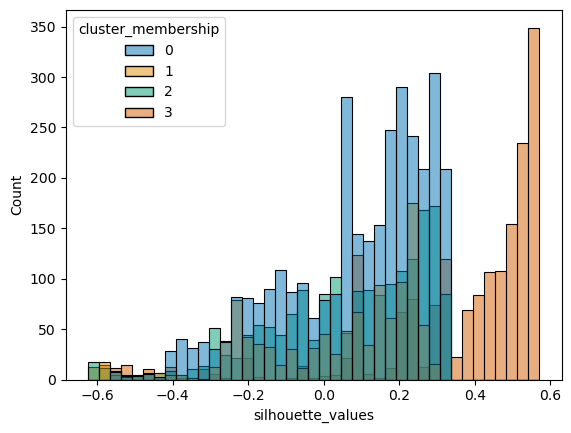

In [95]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [96]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.13107432726085186


Having established the process, we can choose an optimal K based on the silhouette scores, and judge each approach based on its optimal cluster arrangement. **Whether the output clusterings are any good**, however, is to be judged *a posteriori*.

In [ ]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(X, categorical=cat_cols)
    
    score=silhouette_score(distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1591, ncost: 976.4389483471957
Run: 1, iteration: 2/100, moves: 725, ncost: 973.7954640816566
Run: 1, iteration: 3/100, moves: 257, ncost: 973.4949747414615
Run: 1, iteration: 4/100, moves: 131, ncost: 973.412814640038
Run: 1, iteration: 5/100, moves: 3, ncost: 973.412761011253
Run: 1, iteration: 6/100, moves: 0, ncost: 973.412761011253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 614, ncost: 1013.4066122050334
Run: 2, iteration: 2/100, moves: 33, ncost: 1013.4034536355751
Run: 2, iteration: 3/100, moves: 1, ncost: 1013.4033369198992
Run: 2, iteration: 4/100, moves: 0, ncost: 1013.4033369198992
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 240, ncost: 1012.09845105181

In [ ]:
scores_dict

{'2': 0.38692787748789065,
 '3': 0.10698093999705256,
 '4': 0.13107432726085186,
 '5': 0.0874242411590957}

Higher is better (Rousseeuw, 1986), so we settle for two clusters. 

In [ ]:
kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
labels = kp.fit_predict(X, categorical=cat_cols)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1591, ncost: 976.4389483471957
Run: 1, iteration: 2/100, moves: 725, ncost: 973.7954640816566
Run: 1, iteration: 3/100, moves: 257, ncost: 973.4949747414615
Run: 1, iteration: 4/100, moves: 131, ncost: 973.412814640038
Run: 1, iteration: 5/100, moves: 3, ncost: 973.412761011253
Run: 1, iteration: 6/100, moves: 0, ncost: 973.412761011253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 614, ncost: 1013.4066122050334
Run: 2, iteration: 2/100, moves: 33, ncost: 1013.4034536355751
Run: 2, iteration: 3/100, moves: 1, ncost: 1013.4033369198992
Run: 2, iteration: 4/100, moves: 0, ncost: 1013.4033369198992
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 240, ncost: 1012.09845105181

In [ ]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.513646,0
1,0.392371,1
2,0.484851,0
3,0.534756,0
4,-0.483099,0


<AxesSubplot:xlabel='silhouette_values', ylabel='Count'>

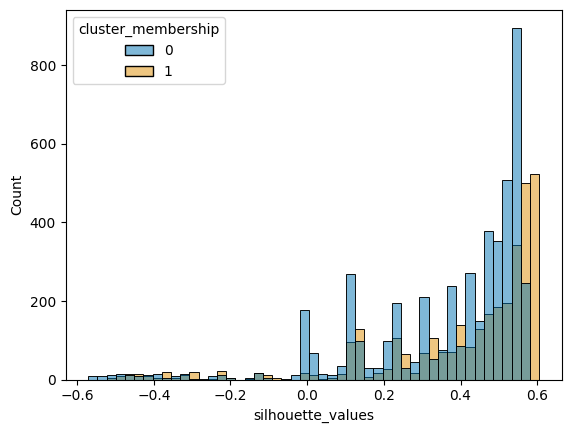

In [ ]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [ ]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.38692787748789065


In [ ]:
# We add cluster membership to the original dataframe to keep track.

movies_metadata['membership_1'] = kp.labels_

Some points in the left tail seem to indicate undesirable clustering, but the general concentration of points in the right indicates that the clusters are differentiated to an agreeable degree.

In [ ]:
centroid_df = pd.DataFrame(kp.cluster_centroids_, columns = list(X_num.columns)+list(X_cat.columns))

In [ ]:
centroid_df.loc[:,X_num.columns] = scaler.inverse_transform(centroid_df[X_num.columns])

In [ ]:
centroid_df

,runtime,vote_average,vote_count,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
0,104.486595,6.717986,335.297657,0,['Drama'],en,['7036'],['US'],['en'],Released
1,96.413117,4.979528,107.926755,0,['Comedy'],en,['1311'],['US'],['en'],Released


In [ ]:
X.groupby('genres').count()['adult'].sort_values(ascending=False).head()

genres
['Drama']               973
['Comedy']              609
['Documentary']         371
['Drama', 'Romance']    249
['Comedy', 'Drama']     239
Name: adult, dtype: int64

In [ ]:
X.groupby('original_language').count()['adult'].sort_values(ascending=False).head()

original_language
en    5430
fr     512
ja     252
es     213
de     208
Name: adult, dtype: int64

In [ ]:
X.groupby('production_companies').count()['adult'].sort_values(ascending=False).head()

production_companies
['2']       20
['7036']    20
['1311']    19
['12']      17
['33']      15
Name: adult, dtype: int64

As expected, the most common categories dominate the cluster centroids with an utter disregard for the contents of the multi-valued categorical attributes.

## Option 2: Apply Multi-Label Binarization. One-hot-encoding across values of all multi-valued attributes.

We may create up to $\sum_{x=1}^{m}{|L|}$ new attributes in the process if all possible levels of the vocabulary are present. If a given clustering is to be re-used for unseen observations, practicioners should be mindful of previously unseen values of the attributes' vocabulary. If no sample containing the complete dictionaries can be assembled, clusters should be fit on the maximum amount of attributes, even if some are empty as a result.

In [57]:
option_2_df = movies_metadata.copy()

In [58]:
option_2_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,membership_1
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629,1
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137,3
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213,1
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323,0
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497,0


In [59]:
option_2_df.index.rename('index', inplace=True)

### 2.1 Data Preparation

In [60]:
columns_to_concat = [option_2_df]
dummy_cols = []
multi_val_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

for attribute in multi_val_cols:
    dummy_df = pd.get_dummies(option_2_df[attribute].apply(pd.Series).stack()).groupby('index', level=0).sum()
    dummy_cols += list(dummy_df.columns)
    columns_to_concat.append(dummy_df)

In [61]:
option_2_df = pd.concat(columns_to_concat, axis=1).drop(multi_val_cols, axis=1)

option_2_df.shape

(8000, 10126)

This approach to clustering multi-valued categorical attributes generates an explosive amount of columns. Common practice involves dropping uncommon labels, at the cost of losing sensitivity to anomalies.

In [63]:
frequencies = pd.DataFrame(option_2_df[dummy_cols].mean(), columns=['freq']).sort_values('freq')

frequencies

,freq
4259,0.000125
54268,0.000125
54259,0.000125
54245,0.000125
54238,0.000125
...,...
Thriller,0.233250
Comedy,0.305750
Drama,0.494875
US,0.521250


In [64]:
frequencies[frequencies.freq >= 0.005]

,freq
HU,0.005000
ta,0.005125
43,0.005125
el,0.005125
14,0.005250
...,...
Thriller,0.233250
Comedy,0.305750
Drama,0.494875
US,0.521250


In [65]:
saved_dummies = list(frequencies[frequencies.freq >= 0.005].index)

saved_cols = ['title', 'adult', 'original_language', 'release_date', 'runtime', 'status', 'vote_average','vote_count'] + saved_dummies

88 rows labels with a frequency of at least 0.5% will be saved.

In [66]:
option_2_df = option_2_df.loc[:,saved_cols]

option_2_df.shape

(8000, 110)

In [67]:
attributes = ['adult', 'original_language', 'runtime', 'status', 'vote_average','vote_count'] + saved_dummies

X = option_2_df.loc[:, attributes]

X.head()

,adult,original_language,runtime,status,vote_average,vote_count,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
index,,,,,,,,,,,,,,,,,,,,,
8968,0,fr,0.125896,Released,0.666667,0.002629,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
10795,0,hi,0.112351,Released,0.488889,0.001137,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8239,0,fr,0.070916,Released,0.777778,0.000213,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
14258,0,en,0.070120,Released,0.633333,0.006323,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14059,0,pt,0.073307,Released,0.477778,0.000497,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [68]:
cat_encoders = dict()
cat_cols = ['adult', 'original_language', 'status']

for col in X.columns:
    if col in cat_cols:
        cat_enc = LabelEncoder()
        X[col] = cat_enc.fit_transform(X.loc[:,col])

        cat_encoders[col] = cat_enc

### 2.2 Clustering

We start by using the silhouette technique to find an optimal k.

In [69]:
cat_col_indexes = [i for i in range(len(X.columns)) if X.columns[i] in (cat_cols + dummy_cols)]
num_col_indexes = list(
    set(cat_col_indexes).symmetric_difference(
        set(range(len(X.columns)))
        )
    )

In [70]:
# K-Prototype uses the squared euclidean to avoid the square root operation

distance_matrix_num = pdist(X.iloc[:, num_col_indexes].values)
distance_matrix_cat = pdist(X.iloc[:, cat_col_indexes].values, 'hamming')
distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [71]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(X, categorical=cat_col_indexes)
    
    score=silhouette_score(distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2546, ncost: 1302.2586989865763
Run: 1, iteration: 2/100, moves: 335, ncost: 1302.1400419422916
Run: 1, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 1, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2439, ncost: 1302.3208285972446
Run: 2, iteration: 2/100, moves: 440, ncost: 1302.1400419422916
Run: 2, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 2, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2448, ncost: 1302.2956280537292
Run: 3, iteration: 2/100, moves: 433, ncost: 1302.1400419422916
Run: 3, iteration: 3/100, moves: 2, ncost: 1302.13988

In [72]:
scores_dict

{'2': 0.041903974132294304,
 '3': -0.08908649484634068,
 '4': -0.05268306368045357,
 '5': -0.08304994791691438}

The dimensionality leads to no good clustering solution existing.

In [73]:
kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
labels = kp.fit_predict(X, categorical=cat_col_indexes)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2546, ncost: 1302.2586989865763
Run: 1, iteration: 2/100, moves: 335, ncost: 1302.1400419422916
Run: 1, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 1, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2439, ncost: 1302.3208285972446
Run: 2, iteration: 2/100, moves: 440, ncost: 1302.1400419422916
Run: 2, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 2, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2448, ncost: 1302.2956280537292
Run: 3, iteration: 2/100, moves: 433, ncost: 1302.1400419422916
Run: 3, iteration: 3/100, moves: 2, ncost: 1302.13988

### 2.3 Evaluation

In [74]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.359602,1
1,-0.074028,1
2,0.286553,1
3,0.364772,1
4,-0.131227,1


<AxesSubplot:xlabel='silhouette_values', ylabel='Count'>

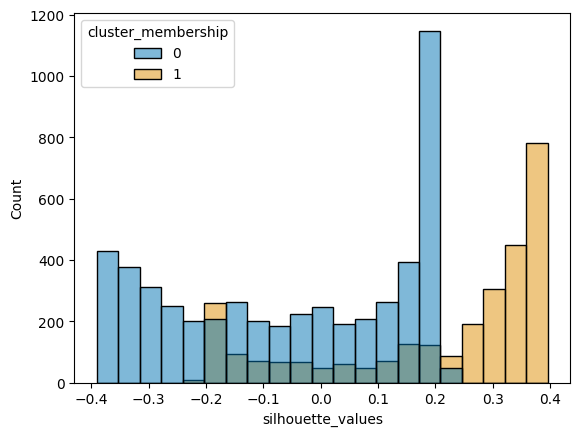

In [75]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [76]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.041903974132294304


In [101]:
centroid_df = pd.DataFrame(kp.cluster_centroids_, columns = list(X.columns[num_col_indexes])+list(X.columns[cat_col_indexes]))
centroid_df.head()

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,0.077149,0.531915,0.024344,0.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.084679,0.600958,0.004413,0.0,19.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [102]:
num_cols = X.columns[num_col_indexes]

centroid_df.loc[:,num_cols] = scaler.inverse_transform(centroid_df[num_cols])

In [105]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,97.822581,5.787233,342.637777,0.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,0.0,19.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [106]:
for col in cat_cols:
    encoder = cat_encoders[col]
    centroid_df[col] = encoder.inverse_transform(centroid_df[col].astype(int))

In [107]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,97.822581,5.787233,342.637777,0,en,Released,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,0,fr,Released,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Fairly close runtimes and vote averages. Both are not differentiated by being adult nor by status. Original language is a differentiating characteristic now.

In [108]:
criteria = centroid_df.iloc[0,:] != centroid_df.iloc[1,:]

criteria

runtime               True
vote_average          True
vote_count            True
adult                False
original_language     True
                     ...  
Thriller             False
Comedy               False
Drama                 True
US                    True
en                    True
Length: 108, dtype: bool

In [109]:
centroid_df[criteria.index[criteria]]

,runtime,vote_average,vote_count,original_language,Drama,US,en
0,97.822581,5.787233,342.637777,en,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,fr,1.0,0.0,0.0


We can see that the categorical differentiators are wether the genre is Drama, wether it was produced in the US, and whether English is spoken in the movie or not. Common appearance of certain characteristics seems to not have influenced cluster assignment.

In [125]:
# We add cluster membership to the original dataframe to keep track.

movies_metadata['membership_2'] = kp.labels_

## Option 3: Add PCA to Option 2 to reduce dimensionality and sparsity.

The main drawback is that adding PCA to the preprocessing reduces generality inasmuch as the principal components may vary with subsamples of the data and entails a loss of interpretability.

In [110]:
option_3_df = movies_metadata.copy()

In [111]:
option_3_df.index.rename('index', inplace=True)

option_3_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
index,,,,,,,,,,,,
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497


In [112]:
columns_to_concat = [option_3_df]
dummy_cols = []
multi_val_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

for attribute in multi_val_cols:
    dummy_df = pd.get_dummies(option_3_df[attribute].apply(pd.Series).stack()).groupby('index', level=0).sum()
    dummy_cols += list(dummy_df.columns)
    columns_to_concat.append(dummy_df)
option_3_df = pd.concat(columns_to_concat, axis=1).drop(multi_val_cols, axis=1)

option_3_df.shape

(8000, 10125)

In [113]:
num_cols = ['runtime', 'vote_average', 'vote_count']
cat_cols = ['adult', 'original_language', 'status']

In [114]:
print(num_cols)
print(cat_cols)

['runtime', 'vote_average', 'vote_count']
['adult', 'original_language', 'status']


In [115]:
try:
    X = option_3_df.drop(['title', 'release_date', 'membership_1', 'membership_2'], axis=1)
except KeyError:
    X = option_3_df.drop(['title', 'release_date'], axis=1)

dummy_cols = list(
    set(X.columns).symmetric_difference(set(num_cols+cat_cols))
)

In [104]:
X.head()

,adult,original_language,runtime,status,vote_average,vote_count,Action,Adventure,Animation,Comedy,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
index,,,,,,,,,,,,,,,,,,,,,
8968,0,fr,0.125896,Released,0.666667,0.002629,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10795,0,hi,0.112351,Released,0.488889,0.001137,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8239,0,fr,0.070916,Released,0.777778,0.000213,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14258,0,en,0.070120,Released,0.633333,0.006323,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14059,0,pt,0.073307,Released,0.477778,0.000497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.1 Data Preparation

In [116]:
X_num = X[num_cols]
X_cat = X[cat_cols]
X_dummies = X[dummy_cols]

#### 3.1.1 Numerical Attributes

In [236]:
# Already scaled at the top section. 

# numerical_scaler = MinMaxScaler()

# X_num = pd.DataFrame(numerical_scaler.fit_transform(X_num.values),
#                      columns=X_num.columns,
#                      index=X_num.index)

In [117]:
X_num.head()

,runtime,vote_average,vote_count
index,,,
8968,0.125896,0.666667,0.002629
10795,0.112351,0.488889,0.001137
8239,0.070916,0.777778,0.000213
14258,0.070120,0.633333,0.006323
14059,0.073307,0.477778,0.000497


#### 3.1.2 Categorical Attributes

In [118]:
cat_encoders = dict()

for col in X_cat.columns:
    cat_enc = LabelEncoder()
    X_cat[col] = cat_enc.fit_transform(X.loc[:,col])

    cat_encoders[col] = cat_enc

C:\Users\manue\AppData\Local\Temp\ipykernel_22064\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = cat_enc.fit_transform(X.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_22064\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = cat_enc.fit_transform(X.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_22064\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [119]:
X_cat.head()

,adult,original_language,status
index,,,
8968,0,19,3
10795,0,21,3
8239,0,19,3
14258,0,14,3
14059,0,48,3


#### 3.1.3 Multi-valued attributes/dummies

In [120]:
X_dummies

,23640,26083,35445,39057,57627,56736,16921,5873,4861,20566,...,21079,12011,1989,1606,24015,47486,86925,34485,6615,7831
index,,,,,,,,,,,,,,,,,,,,,
8968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to use Minka's MLE, we need more samples than features. Aiming at a 5-to-1 ratio, this means preserving the 1600 most-populated dummies.

In [121]:
frequencies = pd.DataFrame(X_dummies.mean(), columns=['freq']).sort_values('freq', ascending=False)
frequencies

,freq
en,0.697125
US,0.521250
Drama,0.494875
Comedy,0.305750
Thriller,0.233250
...,...
26087,0.000125
15048,0.000125
5450,0.000125
93186,0.000125


In [122]:
saved_dummies = list(frequencies.iloc[:1600].index)

In [123]:
saved_dummies = list(frequencies.iloc[:1600].index)

saved_cols = saved_dummies
X_dummies = X_dummies.loc[:,saved_cols]

X_dummies.shape

(8000, 1600)

In [124]:
# Update the list
dummy_cols = X_dummies.columns

Having repeated the process in Option 2, we add a PCA step using Minka's MLE (2000) for an automatic choice of dimensionality.

PCA will take a long time.

In [125]:
from sklearn.decomposition import PCA
import datetime as dt

In [126]:
X_dummies.shape

(8000, 1600)

PCA's computational complexity is exponential (about $O(p^2n+p^3)$), so testing varying amounts of features is valuable to estimate runtime.

In [127]:
execution_time = []

for d in [50, 100, 150, 200, 300, 400, 500]:
    start = dt.datetime.now()
    PCA(
        n_components='mle',
        whiten=True     # Vectors are scaled to unit variance so that we can use them as numeric attributes
    ).fit_transform(X_dummies.iloc[:,:d])
    end = dt.datetime.now()
    execution_time.append((end-start).total_seconds())

c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

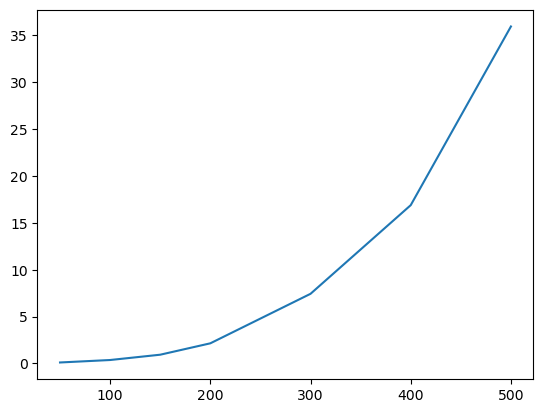

In [128]:
import seaborn as sns

sns.lineplot(x=[50, 100, 150, 200, 300, 400, 500], y=execution_time)

Using all the 1600 features should entail around $11.56\times$ the number of operations. 

In [129]:
p = 400
n = X.shape[0]
new_p = 500

expected_multiplier = (
        ((new_p**2) * n) + (new_p**3)
    )/(
        ((p**2) * n) + (p**3)
    )
print(f'Expected multiplier: {expected_multiplier}')

print(execution_time[-2]*expected_multiplier)
print(execution_time[-1])

Expected multiplier: 1.5811011904761905
26.696503069196428
35.939967


The calculation has some margin of error due to overhead. Let's extrapolate:

In [130]:
p = 500
n = X_dummies.shape[0]
new_p = X_dummies.shape[1]

expected_multiplier = (
        ((new_p**2) * n) + (new_p**3)
    )/(
        ((p**2) * n) + (p**3)
    )
print(f'Expected multiplier: {expected_multiplier}')

print(f"{execution_time[-1]*expected_multiplier / 60} minutes")

Expected multiplier: 11.565176470588236
6.927534345035295 minutes


We can expect the PCA for the totality of dummies to take about 12 times more time than for 500 dummies.

In [190]:
start = dt.datetime.now()

pca = PCA(
    n_components='mle',
    whiten=True     # Vectors are scaled to unit variance so that we can use them as numeric attributes
    )  

X_reduced_dummies = pca.fit_transform(X_dummies)

end = dt.datetime.now()

In [191]:
delta = end - start
print(f"Time difference is {delta.total_seconds()/60} minutes.")

Time difference is 18.041820716666667 minutes.


In [193]:
X_reduced_dummies.shape

(8000, 1597)

### 3.2.1 Clustering with MLE PCA

Seeing that the number of reduced features is still very high, we can force a reasonable number of components like 150.

In [204]:
pca_cols = [f'component_'+str(col) for col in range(X_reduced_dummies.shape[1])]

X_reduced_dummies = pd.DataFrame(X_reduced_dummies, columns=pca_cols)

In [206]:
X_reduced_dummies.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_190,component_191,component_192,component_193,component_194,component_195,component_196,component_197,component_198,component_199
0,1.201171,0.394785,-0.819047,-1.661445,-0.721787,2.362420,-0.081885,-0.106882,0.233370,0.334837,...,-0.040814,-1.035000,-0.445324,0.358288,0.060816,0.056375,0.517117,0.407214,-0.795663,-0.772734
1,0.914268,-1.460102,1.231565,0.308601,0.573338,-1.260331,-0.175274,-0.580852,-0.345987,-0.075066,...,-0.358540,-0.229602,-0.293601,-0.213532,0.116813,0.212996,0.008799,0.185327,0.107847,-0.230706
2,1.411835,-0.250899,1.285488,-2.084514,-1.624124,1.799241,-0.531727,-0.481842,-1.782352,0.632074,...,0.049877,0.015165,0.211054,0.020241,-0.366813,0.381444,-0.260127,-0.336822,0.002803,0.467567
3,0.516221,0.549355,-0.959491,-0.133620,-0.873136,-0.280013,2.520401,-0.954263,0.817811,-0.196019,...,-1.356049,4.224866,0.435831,-1.524129,-2.325333,1.325957,2.156924,5.447166,-3.049181,0.477921
4,1.368371,0.309230,-0.285147,0.611317,-0.735026,-0.837520,-0.626029,-0.383200,0.046503,0.082204,...,0.002480,0.319383,0.233774,-0.486943,0.032921,0.341676,0.071371,-0.473866,-0.164607,-0.367162


### 3.2.2 Clustering with $1/4$ of dummies as components only

In [131]:
start = dt.datetime.now()

pca = PCA(
    n_components=int(X_dummies.shape[1]/4),
    whiten=True
    )  

X_reduced_dummies = pca.fit_transform(X_dummies)

end = dt.datetime.now()

In [134]:
delta = end - start
time = delta.total_seconds()

if time < 100:
    print(f"Time difference is {time} seconds.")
else:
    print(f"Time difference is {delta.total_seconds()/60} minutes.")

Time difference is 2.308375 seconds.


In [135]:
X_reduced_dummies.shape

(8000, 400)

In [136]:
pca_cols = [f'component_'+str(col) for col in range(X_reduced_dummies.shape[1])]

X_reduced_dummies = pd.DataFrame(X_reduced_dummies, columns=pca_cols, index=X_dummies.index)

In [137]:
X_reduced_dummies.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_390,component_391,component_392,component_393,component_394,component_395,component_396,component_397,component_398,component_399
index,,,,,,,,,,,,,,,,,,,,,
8968,1.201175,0.394764,-0.819072,-1.661159,-0.721958,2.362534,-0.082190,-0.106648,0.233429,0.335611,...,2.094305,-0.381118,0.769853,-0.768151,-1.111292,-0.683197,1.322675,-2.015958,0.045314,-0.238805
10795,0.914290,-1.460069,1.231568,0.308407,0.573351,-1.260431,-0.175118,-0.580837,-0.345919,-0.074601,...,-0.110349,0.222943,-0.012599,0.114503,0.113097,0.056890,0.057418,-0.043737,0.225514,0.057137
8239,1.411855,-0.250872,1.285446,-2.084205,-1.624395,1.799343,-0.531870,-0.481885,-1.782325,0.630694,...,-0.084423,-0.074386,-0.005972,-0.386544,-0.077855,0.189934,-0.181215,0.126680,-0.308882,0.315469
14258,0.516227,0.549344,-0.959522,-0.133546,-0.873121,-0.279767,2.520434,-0.954261,0.817954,-0.195136,...,-0.674620,0.220635,0.000607,-0.601528,0.182454,0.800793,-0.372107,1.039955,-0.138783,1.056958
14059,1.368386,0.309225,-0.285180,0.611331,-0.734951,-0.837637,-0.625921,-0.383147,0.046525,0.082719,...,0.114033,-0.009324,-0.291343,0.078568,0.059096,0.109998,-0.057815,0.151221,-0.231272,0.087859


In [160]:
joint_X = pd.concat([X_num, X_cat, X_reduced_dummies], axis=1)

joint_X.head()

,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_390,component_391,component_392,component_393,component_394,component_395,component_396,component_397,component_398,component_399
index,,,,,,,,,,,,,,,,,,,,,
8968,0.125896,0.666667,0.002629,0,19,3,1.201175,0.394764,-0.819072,-1.661159,...,2.094305,-0.381118,0.769853,-0.768151,-1.111292,-0.683197,1.322675,-2.015958,0.045314,-0.238805
10795,0.112351,0.488889,0.001137,0,21,3,0.914290,-1.460069,1.231568,0.308407,...,-0.110349,0.222943,-0.012599,0.114503,0.113097,0.056890,0.057418,-0.043737,0.225514,0.057137
8239,0.070916,0.777778,0.000213,0,19,3,1.411855,-0.250872,1.285446,-2.084205,...,-0.084423,-0.074386,-0.005972,-0.386544,-0.077855,0.189934,-0.181215,0.126680,-0.308882,0.315469
14258,0.070120,0.633333,0.006323,0,14,3,0.516227,0.549344,-0.959522,-0.133546,...,-0.674620,0.220635,0.000607,-0.601528,0.182454,0.800793,-0.372107,1.039955,-0.138783,1.056958
14059,0.073307,0.477778,0.000497,0,48,3,1.368386,0.309225,-0.285180,0.611331,...,0.114033,-0.009324,-0.291343,0.078568,0.059096,0.109998,-0.057815,0.151221,-0.231272,0.087859


Let's cluster now.

In [161]:
cat_col_indexes = [i for i in range(len(joint_X.columns)) if joint_X.columns[i] in (cat_cols)]
num_col_indexes = list(
    set(cat_col_indexes).symmetric_difference(
        set(range(len(joint_X.columns)))
        )
    )

In [153]:
# K-Prototype uses the squared euclidean to avoid the square root operation

heur_distance_matrix_num = pdist(joint_X.iloc[:, num_col_indexes].values)
heur_distance_matrix_cat = pdist(joint_X.iloc[:, cat_col_indexes].values, 'hamming')
heur_distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [148]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(joint_X, categorical=cat_col_indexes)
    
    score=silhouette_score(heur_distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 751, ncost: 3195539.1007591262
Run: 1, iteration: 2/100, moves: 424, ncost: 3195306.721885979
Run: 1, iteration: 3/100, moves: 384, ncost: 3195048.1681872364
Run: 1, iteration: 4/100, moves: 370, ncost: 3194766.1690857
Run: 1, iteration: 5/100, moves: 300, ncost: 3194505.584252984
Run: 1, iteration: 6/100, moves: 177, ncost: 3194367.904560605
Run: 1, iteration: 7/100, moves: 118, ncost: 3194256.1974805375
Run: 1, iteration: 8/100, moves: 91, ncost: 3194182.9016405637
Run: 1, iteration: 9/100, moves: 50, ncost: 3194133.0427306592
Run: 1, iteration: 10/100, moves: 32, ncost: 3194103.8570370893
Run: 1, iteration: 11/100, moves: 17, ncost: 3194088.392453648
Run: 1, iteration: 12/100, moves: 11, ncost: 3194079.809455331
Run: 1, iteration: 13/100, moves: 10, ncost: 3194073.981095551
Run: 1, iteration: 14/100, moves: 4, ncost: 3194072.0936622196
Run: 1, iteration: 15/100, moves: 3,

In [149]:
scores_dict

{'2': 0.18929490181321654,
 '3': 0.19570827027566945,
 '4': 0.13932201753163032,
 '5': 0.16572614604977617}

In [171]:
heuristic_kp = KPrototypes(n_clusters=3, init='Cao', verbose=True, random_state=42)
heurisitc_labels = heuristic_kp.fit_predict(joint_X, categorical=cat_col_indexes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1129, ncost: 3189187.349773322
Run: 1, iteration: 2/100, moves: 673, ncost: 3188259.612912993
Run: 1, iteration: 3/100, moves: 562, ncost: 3187569.9641801743
Run: 1, iteration: 4/100, moves: 233, ncost: 3187334.2768912725
Run: 1, iteration: 5/100, moves: 125, ncost: 3187191.6897541215
Run: 1, iteration: 6/100, moves: 85, ncost: 3187094.464970672
Run: 1, iteration: 7/100, moves: 59, ncost: 3187022.391052587
Run: 1, iteration: 8/100, moves: 25, ncost: 3186986.430782692
Run: 1, iteration: 9/100, moves: 15, ncost: 3186978.9462831705
Run: 1, iteration: 10/100, moves: 7, ncost: 3186976.37336797
Run: 1, iteration: 11/100, moves: 9, ncost: 3186972.4142539874
Run: 1, iteration: 12/100, moves: 2, ncost: 3186971.232893297
Run: 1, iteration: 13/100, moves: 1, ncost: 3186970.659274826
Run: 1, iteration: 14/100, moves: 0, ncost: 3186970.659274826
Init: initializing centroids
Init: initial

### 3.3 Evaluation

#### 3.3.1 Evaluation using MLE

#### 3.3.2 Evaluation using the size heuristic for components

In [172]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(heur_distance_matrix, heuristic_kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = heuristic_kp.labels_

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.159373,2
1,0.338447,2
2,0.265655,2
3,0.167443,2
4,-0.224244,0


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto

<Axes: xlabel='silhouette_values', ylabel='Count'>

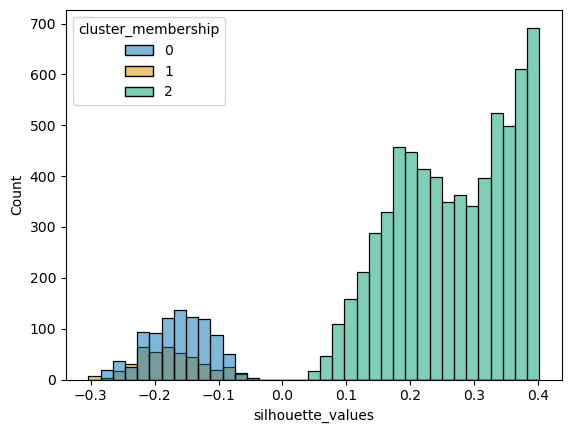

In [173]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [174]:
score=silhouette_score(heur_distance_matrix, heuristic_kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.19526322230657905


In [175]:
centroid_df = pd.DataFrame(heuristic_kp.cluster_centroids_, columns = list(joint_X.columns[num_col_indexes])+list(joint_X.columns[cat_col_indexes]))
centroid_df.head()

,runtime,vote_average,vote_count,component_0,component_1,component_2,component_3,component_4,component_5,component_6,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,adult,original_language,status
0,0.083976,0.581662,0.032085,0.046542,0.133636,-0.125507,0.201296,0.095224,0.072391,0.037297,...,0.030484,0.090415,-0.015063,-0.057102,-0.002175,0.016377,0.065285,0.0,14.0,3.0
1,0.082423,0.591811,0.035226,0.258918,0.042685,0.164479,-0.075898,0.114658,0.484557,0.045701,...,-0.099047,0.013089,-0.026177,0.032796,0.064834,-0.066223,-0.077695,0.0,14.0,3.0
2,0.079099,0.550835,0.014038,-0.022852,-0.021194,0.006937,-0.023038,-0.020443,-0.040732,-0.008057,...,0.002061,-0.013339,0.003743,0.005821,-0.003809,0.001932,-0.004107,0.0,14.0,3.0


In [176]:
centroid_df.loc[:,num_cols] = scaler.inverse_transform(centroid_df[num_cols])

In [177]:
centroid_df

,runtime,vote_average,vote_count,component_0,component_1,component_2,component_3,component_4,component_5,component_6,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,adult,original_language,status
0,106.389794,6.234962,451.600434,0.046542,0.133636,-0.125507,0.201296,0.095224,0.072391,0.037297,...,0.030484,0.090415,-0.015063,-0.057102,-0.002175,0.016377,0.065285,0.0,14.0,3.0
1,104.440758,6.326303,495.805687,0.258918,0.042685,0.164479,-0.075898,0.114658,0.484557,0.045701,...,-0.099047,0.013089,-0.026177,0.032796,0.064834,-0.066223,-0.077695,0.0,14.0,3.0
2,100.268890,5.957518,197.583897,-0.022852,-0.021194,0.006937,-0.023038,-0.020443,-0.040732,-0.008057,...,0.002061,-0.013339,0.003743,0.005821,-0.003809,0.001932,-0.004107,0.0,14.0,3.0


Clusters 0 and 1 seem to be rather similar except for the components. There are no differences in the categorical columns.

In [178]:
for col in cat_cols:
    encoder = cat_encoders[col]
    centroid_df[col] = encoder.inverse_transform(centroid_df[col].astype(int))

In [179]:
centroid_df

,runtime,vote_average,vote_count,component_0,component_1,component_2,component_3,component_4,component_5,component_6,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,adult,original_language,status
0,106.389794,6.234962,451.600434,0.046542,0.133636,-0.125507,0.201296,0.095224,0.072391,0.037297,...,0.030484,0.090415,-0.015063,-0.057102,-0.002175,0.016377,0.065285,0,en,Released
1,104.440758,6.326303,495.805687,0.258918,0.042685,0.164479,-0.075898,0.114658,0.484557,0.045701,...,-0.099047,0.013089,-0.026177,0.032796,0.064834,-0.066223,-0.077695,0,en,Released
2,100.268890,5.957518,197.583897,-0.022852,-0.021194,0.006937,-0.023038,-0.020443,-0.040732,-0.008057,...,0.002061,-0.013339,0.003743,0.005821,-0.003809,0.001932,-0.004107,0,en,Released


Non-Adult, English and Released movies. Adding the information in the multi-valued categorical attributes into the numeric component of the sum of distances has led to the gamma being too low for the categorical elements to influence the clustering.

In [180]:
# We save the results in the original dataframe

movies_metadata['membership_2_heur'] = heuristic_kp.labels_

## Option 4: Apply the extended K-Prototypes.